In [183]:
import pandas as pd
import multiprocessing as mp
import wtfutil as wtf
import pathlib
import datetime as dt
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pprint
import numpy as np

In [184]:
DATE_REF=dt.datetime.utcnow().date() - dt.timedelta(days=1)
PATH_PREFIX=DATE_REF.strftime('data/%Y/%m/%d/')

rawdata = dict()
aggdata = dict()

dfs = dict()

def process(path, buckets=20):
    _, timestamp, _ = path.name.split('_')
    ts = pd.Timestamp(dt.datetime.fromtimestamp(int(timestamp)))
    
    
    df = pq.read_table(path.open('rb'), columns=['satoshi', 'vsize', 'diff']).to_pandas()
#    agg_add = wtf.feeagg(df.query('diff == 1'), buckets=buckets)
#     agg_del = wtf.feeagg(df.query('diff == -1'), buckets=buckets)
#    agg = agg_add
#    agg = wtf.feeagg(df)
#    series = [agg[c].add_prefix(f'{c}-').add_suffix(f'_{buckets}') for c in agg.columns]
#    series = []
#    return (ts, pd.concat(series))

    return (ts, df)

def pr_aggregate(lst): # lst = [(ts, df),...]
    ts = lst[0][0]
    ts.date()
    idx = pd.date_range(ts.date(), periods=144, freq='10T')
    data = [list() for n in range(144)]
    series = []
    
    for ts, df in lst:
        t = ts.time()
        n = int((t.hour * 60 * 60 + t.minute * 60 + t.second)/600)
        data[n].append(df)
    
    for n, dfs in enumerate(data):
        scalar = 40/len(dfs)
        df_concat = pd.concat(dfs).query('diff == 1')
        series.append(wtf.feeagg(df_concat).stack() * scalar)
    
    return pd.DataFrame(series, index=idx).swaplevel(axis=1)



def mp_load(date_ref, use_cache=True):
    if not date_ref in rawdata:
        with mp.Pool(16) as p:
            path_prefix = date_ref.strftime('data/%Y/%m/%d/')
            it_paths = pathlib.Path(path_prefix).glob('*_diff.parq')
            rawdata[date_ref] = p.map(process, it_paths)

    return rawdata[date_ref]
    


In [222]:
%%time
i=0
date_now = dt.datetime.utcnow().date()
date_ref = date_now - dt.timedelta(days=i+1)
path_prefix = date_ref.strftime('data/%Y/%m/%d/')
it_paths = pathlib.Path(path_prefix).glob('*_diff.parq')


idx = pd.date_range(date_ref, periods=144, freq='10T')

data = [list() for n in range(144)]

for path in it_paths:
    _, timestamp, _ = path.name.split('_')
    t = dt.datetime.fromtimestamp(int(timestamp))
    n = int((t.hour * 60 * 60 + t.minute * 60 + t.second)/600)
    data[n].append(path)
    


def mp_loadandnagg(paths, normalize=40):
    dfs = [pq.read_table(path.open('rb'), columns=['satoshi', 'vsize', 'diff']).to_pandas() for path in paths]
    mvs = wtf.feeagg(pd.concat(dfs).query('diff == 1')).mvs / len(d) * normalize
    return mvs

with mp.Pool() as p:
    results = p.map(mp_loadandnagg, data)

#pd.DataFrame(data=results, )



results[0]

CPU times: user 108 ms, sys: 68 ms, total: 176 ms
Wall time: 947 ms


In [223]:
%%time
results[0]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


feerate_lfb
800    0.000000
760    0.000000
720    0.000237
680    0.000472
640    0.003993
600    0.005318
560    0.014684
520    0.010567
480    0.159624
440    0.021621
400    0.058337
360    0.014239
320    0.022739
280    0.013297
240    0.011895
200    0.018401
160    1.066801
120    0.000161
80     0.000175
40     0.155361
0      0.010169
Name: mvs, dtype: float64

In [191]:
%%time 
a = df.astype(np.float16)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 468 µs


array([   0,    1,    2, ..., 9997, 9998, 9999])

In [221]:
pd.Series(np.random.rand(10000)).quantile(np.arange(100)/100)

0.00    0.000036
0.01    0.009704
0.02    0.020233
0.03    0.030311
0.04    0.038785
0.05    0.049819
0.06    0.059486
0.07    0.069320
0.08    0.079038
0.09    0.089217
0.10    0.098296
0.11    0.109251
0.12    0.119336
0.13    0.129207
0.14    0.139025
0.15    0.149056
0.16    0.160021
0.17    0.169794
0.18    0.179835
0.19    0.190442
0.20    0.199734
0.21    0.208927
0.22    0.219490
0.23    0.229648
0.24    0.239176
0.25    0.250450
0.26    0.258166
0.27    0.267140
0.28    0.275640
0.29    0.286091
          ...   
0.70    0.696910
0.71    0.705010
0.72    0.715186
0.73    0.724397
0.74    0.734026
0.75    0.744367
0.76    0.755080
0.77    0.766223
0.78    0.777693
0.79    0.787632
0.80    0.800835
0.81    0.811387
0.82    0.822294
0.83    0.832450
0.84    0.842759
0.85    0.853471
0.86    0.863187
0.87    0.873340
0.88    0.881784
0.89    0.889788
0.90    0.900265
0.91    0.907961
0.92    0.918855
0.93    0.927356
0.94    0.938045
0.95    0.948007
0.96    0.958824
0.97    0.9693

In [115]:
%%time

# load it into memory (may take 60 seconds)
for i in range(1):
    date_now = dt.datetime.utcnow().date()
    date_ref = date_now - dt.timedelta(days=i+1)
    mp_load(date_ref)
    



CPU times: user 1.34 s, sys: 112 ms, total: 1.45 s
Wall time: 1.67 s


In [116]:
%%time

with mp.Pool(16) as p:
    aggdata = p.map(pr_aggregate, rawdata.values())


CPU times: user 504 ms, sys: 92 ms, total: 596 ms
Wall time: 3.74 s


In [117]:
def draw(df, ylim=[0,1]):
    fig = plt.figure(figsize=(16,2), dpi=72)
    title = df.index[0].strftime('%Y-%m-%d (%A)')
    ax = plt.subplot(111)
    ax.set_ylim(ylim)
    ax.set_axis_off()
    fig.add_axes(ax)
    pdf = df
    pdf = pdf.resample('60T', convention='s').sum()/6
    pdf.plot(
        kind='bar', 
        stacked=True,
        colormap='tab20b_r', 
        ax=ax, 
        legend=False, 
        title=title,
    )
    plt.axis('off')
    plt.show()

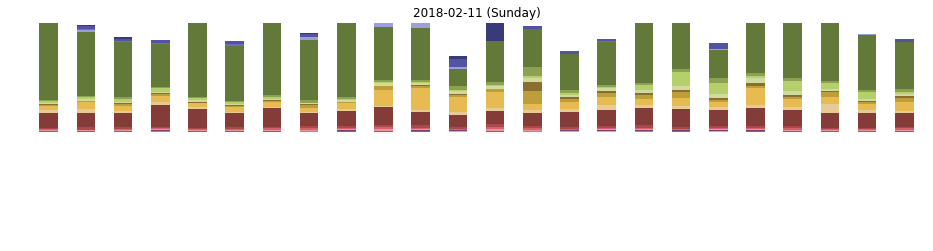

In [118]:
#draw(df[df.columns[1::]], ylim=[1,2])
draw(df[df.columns[1::]])

In [119]:
df

feerate_lfb,800,760,720,680,640,600,560,520,480,440,...,360,320,280,240,200,160,120,80,40,0
2018-02-11 00:00:00,0.000000,0.000000,0.000237,0.000472,0.003993,0.005318,0.014684,0.010567,0.159624,0.021621,...,0.014239,0.022739,0.013297,0.011895,0.018401,1.066801,0.000161,0.000175,0.155361,0.010169
2018-02-11 00:10:00,0.000000,0.000000,0.000237,0.000951,0.002173,0.004304,0.010688,0.014182,0.159961,0.029097,...,0.006743,0.003703,0.011903,0.016994,0.014736,1.157286,0.000593,0.002405,0.004100,0.000463
2018-02-11 00:20:00,0.000238,0.000000,0.000235,0.000863,0.005265,0.004659,0.008651,0.014555,0.110664,0.038747,...,0.005367,0.002349,0.014439,0.007956,0.009429,0.403461,0.000432,0.002503,0.000000,0.001000
2018-02-11 00:30:00,0.000000,0.000951,0.000476,0.001246,0.001648,0.005338,0.008138,0.011842,0.148269,0.027912,...,0.007247,0.003247,0.008472,0.010185,0.011531,0.335891,0.021517,0.000237,0.158122,0.000729
2018-02-11 00:40:00,0.000000,0.000000,0.000000,0.001314,0.003655,0.003805,0.010109,0.012907,0.131716,0.025106,...,0.003967,0.002622,0.018323,0.023706,0.014740,0.543016,0.021299,0.000474,0.000000,0.000851
2018-02-11 00:50:00,0.000237,0.000000,0.000000,0.002725,0.002466,0.009878,0.012105,0.029994,0.110119,0.022284,...,0.004111,0.003247,0.018899,0.008987,0.018312,0.872202,0.010819,0.000000,0.000000,0.000202
2018-02-11 01:00:00,0.000000,0.000000,0.000000,0.000641,0.004381,0.005004,0.006160,0.021054,0.225573,0.036773,...,0.006927,0.007885,0.014327,0.013115,0.007469,1.575761,0.050713,0.000456,0.077666,0.001236
2018-02-11 01:10:00,0.000237,0.000000,0.000000,0.002053,0.004802,0.007669,0.004329,0.011003,0.124359,0.021879,...,0.004978,0.003845,0.017833,0.035314,0.006527,0.066033,0.011868,0.000000,0.003823,0.059582
2018-02-11 01:20:00,0.000000,0.000273,0.000000,0.001315,0.006745,0.004717,0.007279,0.015846,0.150243,0.108039,...,0.005857,0.006806,0.008586,0.023960,0.004185,1.327933,0.000992,0.009915,0.000000,0.000678
2018-02-11 01:30:00,0.000000,0.000000,0.000357,0.001616,0.004860,0.002760,0.007355,0.024743,0.118727,0.022893,...,0.003659,0.004036,0.019185,0.015849,0.007754,0.497072,0.021138,0.020029,0.077674,0.000694


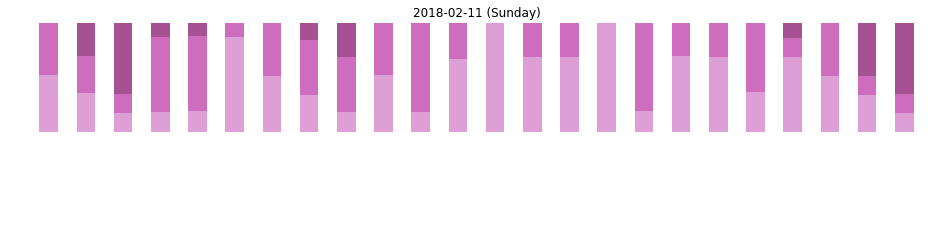

IndexError: list index out of range

In [120]:
for i in range(28):
    draw(aggdata[i])

In [122]:
%%time

for i in range(3):
    date_ref = datetime.datetime.utcnow().date() - datetime.timedelta(days=1) - datetime.timedelta(days=i)
    res = mp_load(date_ref)
    ts = res[0][0]
    empty_df = pd.DataFrame(index=pd.date_range(ts.date(), periods=60*60*24/15, freq='15S'))
    partial_df = pd.DataFrame.from_items(res).T
    full_df = pd.concat([empty_df, partial_df], axis=1)
    
    title = date_ref.strftime('%Y-%m-%d (%A)')
    resampled_df = full_df.resample('20T', convention='s').sum()/2
    fig = plt.figure(figsize=(16,2), dpi=72)
    ax = plt.subplot(111)
    ax.set_ylim([0,2.5])
    cols = list(filter(lambda x: x.startswith('mvs'), resampled_df.columns))[::-1]
    resampled_df = pd.np.maximum(resampled_df, 0)

    resampled_df[cols].plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title=title)

    plt.show()


NameError: name 'datetime' is not defined

0     0.000000
1     0.000000
2     0.095497
3     0.000000
4     0.000000
5     0.069957
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.166363
11    0.205364
12    0.000000
13    0.086532
14    0.000000
15    0.089933
16    0.477869
17    0.000000
18    0.000000
19    0.347020
dtype: float64